# [Optional] Creating your own Cell Metrics

**Estimated time to run through notebook is 20 minutes** 


Chapter 4 showed how to visualize and analyze existing cell metrics. This notebook focuses on how to use image data to create a new cell metric for a classifier.

This notebook shows how to:
-  [sample image and explore image data](#distance)
-  [create a metric for nuclear volume from the nuclear segmentation channel](#nuclearvolume) 
(How to read images and perform simple operations on a CZYX array)
-  [create a metric for distance between cell membrane and nucleus](#membranenucleusdistance)
(How to parallelize read operations and read multiple channels)
-  [create a metric for the percentage volume of a cell that is occupied by microtubules](#percentvolume)
(How to create a metric that could be of biological relevance)

## <a id='preprocessing'></a>Load libraries and manifest

The following cell loads the relevant libraries and the manifest containing the images we will be using. 

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from aicsimageprocessing import diagnostic_sheet, read_ome_zarr, rescale_image, imgtoprojection
from upath import UPath as Path
import warnings
from aicsimageio import transforms, AICSImage
import nbvv
import os
import numpy as np
import time
from scipy.spatial import distance
df = pd.read_parquet("s3://allencell-cytodata-variance-data/processed/hackathon_manifest_09292022.parquet")
print(f'Number of cells: {len(df)}')
print(f'Number of columns: {len(df.columns)}')

Number of cells: 214037
Number of columns: 78


## <a id='distance'></a> Sample Image and Explore Data



Similar to Chapter 3, we will be sampling images and exploring their different channels. The following code cell samples a cell image and uses the read_ome_zarr function from AICSImageIO to obtain the image data in CZYX shape. img_data is an image representation of shape CZYX - where C is the channel, and Z, Y and X are the spatial dimensions. 

Note - you can pass in "level = 2" as a parameter in  read_ome_zarr for lower resolution images.

Voxel Sizes are  0.108333<sup>3</sup> 𝜇m<sup>3</sup>.


In [77]:
some_cell = df.sample(1).iloc[0]
full_img = read_ome_zarr(some_cell["registered_path"], level = 2)
img_data = full_img.data.squeeze()
img_data.shape


(7, 32, 60, 94)

Here, we see that images have 7 channels. They are 

- bf - brightfield channel 
- dna - dna intensity channel
- membrane - membrane intensity channel
- structure - structure intensity channel
- dna_segmentation - segmentation of the dna channel
- membrane_segmentation - segmentation of the membrane channel
- struct_segmentation_roof - segmentation of the structure channel

In [78]:
# Images have 7 channels for brightfield + DNA, membrane, and structure intensity and segmentation channels
full_img.channel_names

['bf',
 'dna',
 'membrane',
 'structure',
 'dna_segmentation',
 'membrane_segmentation',
 'struct_segmentation_roof']

## <a id='nuclearvolume'></a> Metric 1: Nuclear Volume
This example is focused on how to read images and perform simple operations on an array containing image data. We will be building a basic cell metric to compute nuclear volume using the dna_segmentation channel which tells us the size and location of the nucleus in a cell image. img_data[4] corresponds to the segmentation of the dna channel and we collect the nuclear pixels using np.nonzero(to count pixels of value 1) and np.transpose(to get the pixel locations in a more readable format). We then find the nuclear volume by multiplying the number of pixels we find by the voxel size.

In [79]:
count = 1
some_cells = df.sample(count)
tic = time.perf_counter()
for index in range(count): 
    full_img = read_ome_zarr(some_cells.iloc[index]["registered_path"]) # returns AICS Image
    img_data = full_img.data.squeeze() #returns 4D CZYX array
    nuclear_pixels = np.transpose(np.nonzero(img_data[4])) #img_data[4] corresponds to the dna_segmentation channel
    #print("Total Number of non-zero elements is: ", len(nuclear_pixels))
    nuc_volume = len(nuclear_pixels) * 0.10833 * 0.10833 * 0.10833
    print("Nuclear Volume is ", nuc_volume, " cubic microns.")

Nuclear Volume is  859.1841684502087  cubic microns.


## <a id='membranenucleusdistance'></a> Metric 2: Distance between Cell Membrane and Nucleus 

This metric example is distance between the nucleus and the cell membrane. We will be using two channels, the membrane segmentation and the DNA segmentation, in order to determine the closest points between our two cellular structures. 


Our first step is to find the edges of the cell membrane and nucleus and then compute the minimum distance between any pair of points on the two edges. The following cell will be a 2D illustration of how we go about edge detection and collection. We will be using the [binary_erosion](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_erosion.html) operation to compute the edges. 

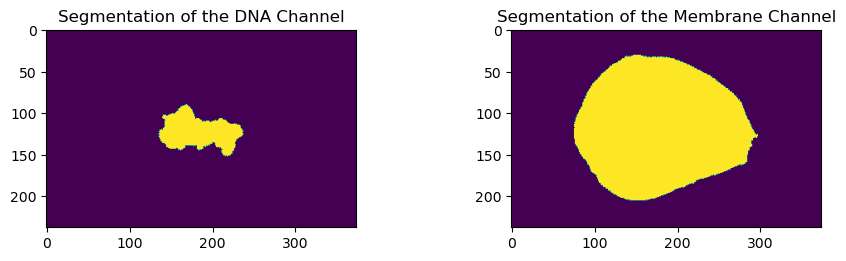

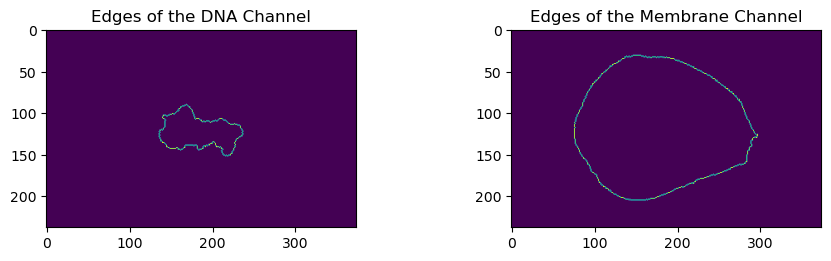

In [98]:
from matplotlib.pyplot import figure
from scipy import ndimage

nuc_seg = img_data[4].max(axis=0) 
mask =  ndimage.binary_erosion(nuc_seg.tolist())
nuc_seg[mask]=0 

cell_seg = img_data[5].max(axis=0) 
mask =  ndimage.binary_erosion(cell_seg.tolist())
cell_seg[mask]=0 


dna_seg = img_data[4].max(axis = 0)
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1) 
plt.style.use("default")
plt.imshow(dna_seg)
plt.title('Segmentation of the DNA Channel')
plt.subplots_adjust(wspace=0.5,hspace=0.4)

#Membrane Segmentation Plot
membrane_segmentation = img_data[5].max(axis = 0)
plt.subplot(1, 2, 2)
plt.style.use("default")
plt.imshow(membrane_segmentation)
plt.title('Segmentation of the Membrane Channel')


dna_seg = img_data[4]
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1) 
plt.style.use("default")
plt.imshow(nuc_seg)
plt.title('Edges of the DNA Channel')
plt.subplots_adjust(wspace=0.5,hspace=0.4)

#Membrane Segmentation Plot
membrane_segmentation = img_data[5]
plt.subplot(1, 2, 2)
plt.style.use("default")
plt.imshow(cell_seg)
plt.title('Edges of the Membrane Channel')
plt.show()

### Parallelizing Image Reads and 3D Distance Computation

We use the AICSImageIO function read_ome_zarr to go from an AICSImage to a CZYX array, however this step can be time-consuming particularly when trying to generate a metric over a large dataset. To speed this up, we will use the concurrent.futures module and threads to parallelize the bottleneck step of reading in images. Next, we will perform the same binary erosion operation seen in the previous cell on 3D images to identify the edges. Once we have the set of nucleus and membrane edges, we will use a kdTree to find the minimum distance between points in the two sets of edges.

In [91]:
from concurrent.futures import ThreadPoolExecutor, as_completed 
from scipy.spatial import cKDTree
import time
count = 1
some_cells = df.sample(count)
tic = time.perf_counter()
chosen_images = []
images_data = []
some_cells['Membrane-Nucleus Distance'] = 0.0
#ThreadPoolExecutor uses a pool of threads to execute calls asynchronously.
with ThreadPoolExecutor() as executor: 
    for index in range(count): 
        #executor.submit schedules the callable, fn, to be executed and and returns a Future object representing the execution of the callable.
        full_img = executor.submit(read_ome_zarr, some_cells.iloc[index]["registered_path"], level = 2)
        chosen_images += [full_img]
        
    for index, image in enumerate(as_completed(chosen_images)): 
        full_img = image
        #print(full_img)
        img_data = full_img.result().data.squeeze()
        images_data += [img_data]

        nuc_edges = img_data[4]
        mask =  ndimage.binary_erosion(nuc_edges.tolist())
        nuc_edges[mask]=0 
        nuc_edges = np.transpose(np.nonzero(nuc_edges))
        #print(nuc_edges)
                
        cell_edges = img_data[5]
        mask =  ndimage.binary_erosion(cell_edges.tolist())
        cell_edges[mask]=0 
        cell_edges = np.transpose(np.nonzero(cell_edges))
        min_dists, min_dist_idx = cKDTree(cell_edges).query(nuc_edges, 1)
        min_dist = min(min_dists)
        some_cells.at[some_cells.index[index], 'Membrane-Nucleus Distance'] = min_dist        
print(some_cells['Membrane-Nucleus Distance'].value_counts())
toc = time.perf_counter()
print(f" took {toc - tic:0.4f} seconds")

0.0    1
Name: Membrane-Nucleus Distance, dtype: int64
 took 0.1272 seconds


## <a id='percentvolume'></a>Metric 3: Percentage of Cell Volume occupied by Microtubules

This example is focused on how to making a metric of biological relevance. We will be utilizing the structure channel and selecting images with "microtubules" as its imaged structure. 

Our goal is to classify cell stage based on microtubules present in a cell. To do this, we will begin by creating a dataset with equal number of elements in each cell stage. 

In [92]:
some_cells = df.loc[df['Structure']=='microtubules']
min_count = some_cells['cell_stage'].value_counts().min() #min_count refers to the minimum number of images present in a cell stage
n = min_count 
cells_to_include=[]
for name, group in some_cells.groupby('cell_stage'):    
    sampled_group = group.sample(n) 
    cells_to_include.append(sampled_group)
df_mitocells = pd.concat(cells_to_include).reset_index(drop=True)
# Discarding all the M6M7_single cells
df_mitocells = df_mitocells.drop(df_mitocells[df_mitocells['cell_stage']=='M6M7_single'].index)


The following cell samples images from our new dataset and the number of images we take in is defined by the variable count. We then identify the number of microtubule pixels and the number of overall cell pixels. Using these two values, we find the percentage volume of the cell that is made up of microtubules, with the idea that there may be some biological relevance to higher microtubule density at a particular cell stage. 

In [97]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
count = 80
some_cells = df_mitocells.sample(count)
tic = time.perf_counter()
some_cells = some_cells.set_index('CellId')
some_cells['Percentage Volume'] = 0
some_cells['Microtubule Pixels'] = 0
#Microtubules
chosen_images = {}
with ThreadPoolExecutor() as executor:
    for sample_number in range(count): 
        full_img = executor.submit(read_ome_zarr, some_cells.iloc[sample_number]["registered_path"])
        chosen_images[some_cells.index[sample_number]] = full_img
    for image_num, index in enumerate(chosen_images): 
        full_img = chosen_images[index]
        img_data = full_img.result().data.squeeze()
        #Nuc_edges = microtubules
        microtubule_pixels=np.transpose(np.nonzero(img_data[6]))
        cell_pixels=np.transpose(np.nonzero(img_data[5]))
        metric = 100* (len(microtubule_pixels)/len(cell_pixels))
        some_cells.at[index, 'Percentage Volume'] = metric
        if image_num%20==0: print("Image ",image_num) #print statement to track progress
toc = time.perf_counter()
print(f" took {toc - tic:0.4f} seconds")

Image  0
Image  20
Image  40
Image  60
 took 89.6655 seconds


The following cell is a violin plot of how percentage volume changes across different cell stages. You can edit the metric variable and see how other metrics such as "Microtubule Pixels" change across different cell stages.

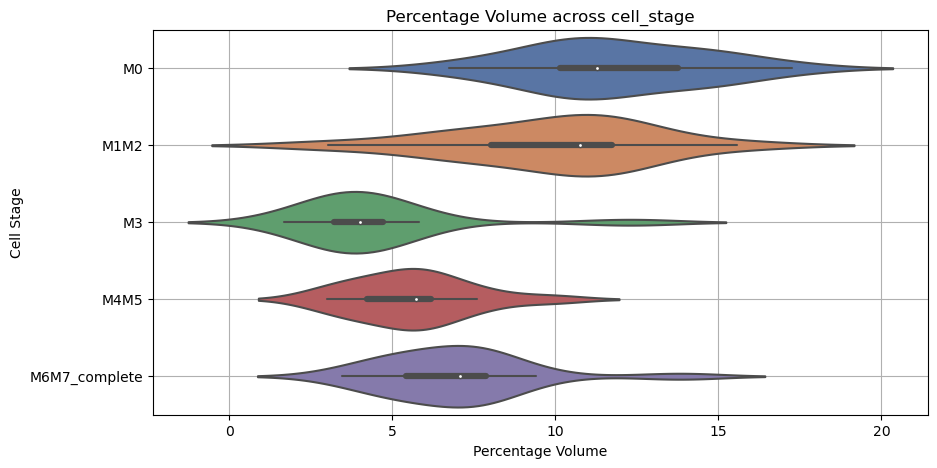

In [99]:
import seaborn as sns
metric = "Percentage Volume" #  metric to plot
stratifier = "cell_stage" #  name of column whose values are used to define sub-populations

order = np.sort(some_cells[stratifier].unique())
fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
sns.set(style="darkgrid")

sns.violinplot(
    y=stratifier,
    x=metric,
    order = order,
    data=some_cells,
    scale="width",
    ax=axes
)

axes.set_title(f"{metric} across {stratifier}")
axes.grid(True, which="major", axis="both")
axes.set_axisbelow(True)
axes.set_ylabel("Cell Stage")
axes.set_xlabel("Percentage Volume")

plt.show()

## <a id='conclusion'></a> Conclusion

In this chapter we explained how to create a new metric and demonstrated various ways to access and analyze data from image channels. 